# Abstract
 

This blog post explores how using a sparse kernel method and how different lambda and gamma values impact the fitting of machine learning methods. Adjusting each of these values impacts the fit and potential overfit of the model. Gamma determines how many of the closest points are taken into account in the classification of each other point, while lambda determines the strength of the regularization of the model—how many or few weights will be forced to be zero.

In [2]:
%load_ext autoreload
%autoreload 2
from sparse_kernel_logistic import KernelLogisticRegression, GradientDescentOptimizer


import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

Let's generate some data that is mostly linearly separable: 

Text(0.5, 0.98, 'Basic Classification Data')

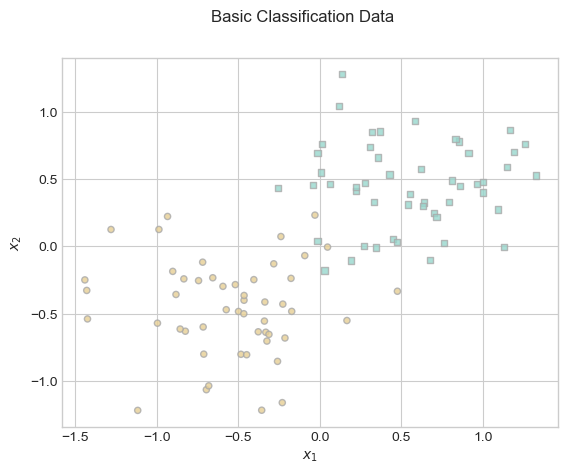

In [3]:
import torch 
from matplotlib import pyplot as plt
import numpy as np

np.random.seed(123)
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)
fig.suptitle("Basic Classification Data")


### Sparce Kernel Machine Class Source Code:

Use this [link](https://github.com/jcummings25/github_jcummings25.github.io/blob/main/posts/Sparse-Kernel-Machines/sparse_kernel_logistic.py) to access the code for our Sparse Kernel Machine. 

For this blog post we will be looking at the use of the rbf_kernel defined in the following code block.

In [4]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)



To start, let's explore how the model is classified using a relatively low lambda of 0.1 and a relatively low gamma of 1. The low lambda will mean that more points will have non-zero weights, but the medium level of gamma means that each point will influence a larger region during classification 

In [ ]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)
(1.0*(KR.a > 0.001)).mean()

tensor(0.1700)

Let's define a function to plot decision boundaries as well as highlighting those points with non-zero values for their weights.

In [103]:
def plot_decision_boundary(KR, X, y, ax = None, highlight = True):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ix = torch.abs(KR.a) > 0.001

    x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
    x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

    x1 = X1.ravel()
    x2 = X2.ravel()

    X_ = torch.stack((x1, x2), dim = 1)

    preds = KR.score(X_, recompute_kernel = True)
    preds = 1.0*torch.reshape(preds, X1.size())


    ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
    vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
    )
    plot_classification_data(X, y, ax)
    if highlight:
        ax.scatter(KR.Xt[ix, 0].detach(), KR.Xt[ix, 1].detach(), 
            facecolors="none", edgecolors="black", linewidths=1.5)

Text(0.5, 1.0, 'Decision boundary with $\\lambda = 0.1$ and $\\gamma = 1$')

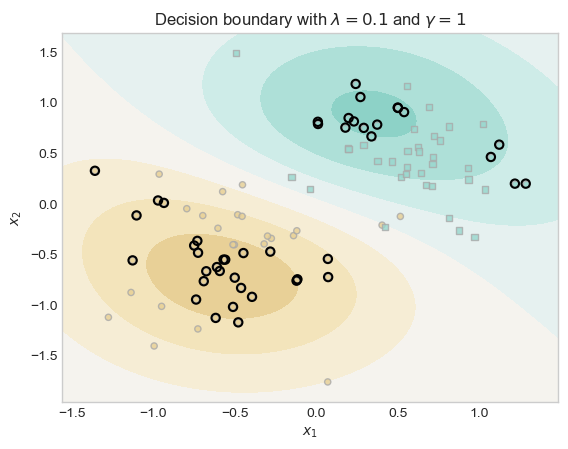

In [65]:


plot_decision_boundary(KR, X, y, ax=None)
plt.title("Decision boundary with $\\lambda = 0.1$ and $\\gamma = 1$")

## Basic Experiments

#### Experiment 1: Large $\lambda$

When ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\lambda$ is very large, there may be only one point in the training data with weight distinguishable from zero.

In [90]:

KR = KernelLogisticRegression(rbf_kernel, lam = 5, gamma = 1)

KR.fit(X, y, m_epochs = 500000, lr = 0.0001)



Text(0.5, 1.0, 'Decision boundary with $\\lambda = 5$ and $\\gamma = 1$')

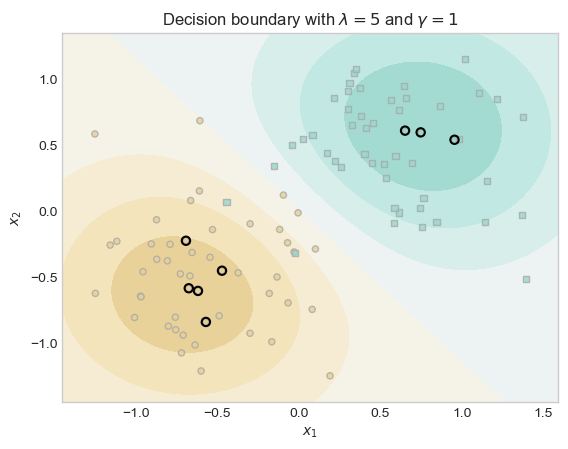

In [86]:
fig, ax = plt.subplots(1, 1)
plot_decision_boundary(KR, X, y, ax)
plt.title("Decision boundary with $\\lambda = 5$ and $\\gamma = 1$")

As we can see in the above visualization, when lambda is high, most of the weights for the points are regularized down to zero. Only a couple of points at most have non-zero weights. 

#### Experiment 2: Changing $\gamma$



With lambda reset to a normal value, and gamma made to a very high bandwidth/value of 10 we will see more points with non-zero weights, as each point has a very local decision region: each point only looks at the points very close to it for classification.

In [ ]:
KR1 = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 10)

KR1.fit(X, y, m_epochs = 500000, lr = 0.0001)

Text(0.5, 1.0, 'Decision boundary with $\\lambda = .1$ and $\\gamma = 10$')

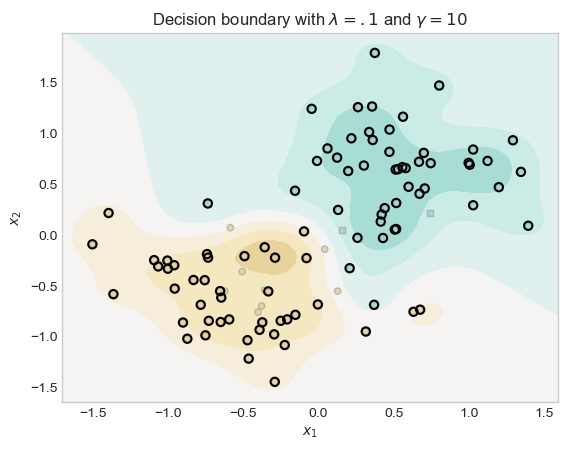

In [ ]:
plot_decision_boundary(KR1, X, y)
plt.title("Decision boundary with $\\lambda = .1$ and $\\gamma = 10$")

As we can see from the large quantity of highlighted plots, as well as the wavy decision boundaries, when gamma is high the decision regions become highly localized to nearby plots. 

#### Experiment 3: Nonlinear Data

Let's use the Moons from Sklearn to generate non-linear data:

Text(0.5, 1.0, 'Moons Dataset: Nonlinearly Separable')

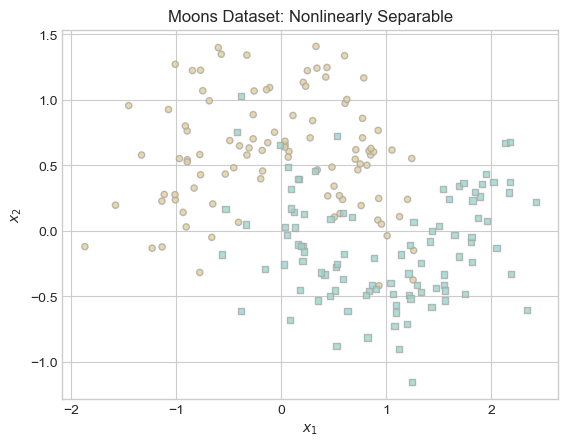

In [92]:
from sklearn.datasets import make_moons

X_np, y_np = make_moons(200, shuffle=True, noise=0.3)

#convert to torch tensors
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)
plt.title("Moons Dataset: Nonlinearly Separable")


In [93]:
KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 5)

KR.fit(X, y, m_epochs = 500000, lr = 0.01)

Text(0.5, 1.0, 'Moons Dataset: Nonlinearly Separable')

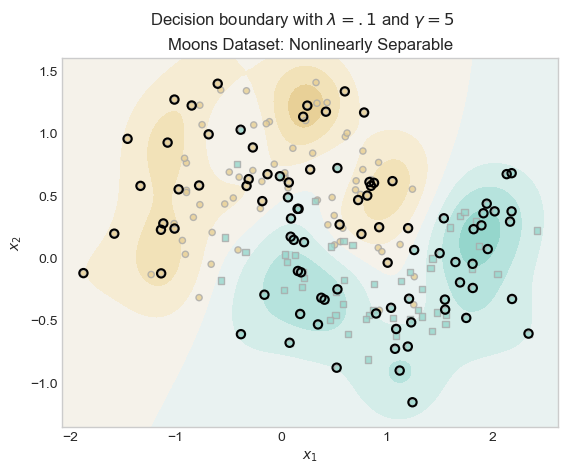

In [94]:
plot_decision_boundary(KR, X, y, ax = None)
plt.suptitle("Decision boundary with $\\lambda = .1$ and $\\gamma = 5$")
plt.title("Moons Dataset: Nonlinearly Separable")

By adjusting the gamma value to be quite high, while leaving the lambda value relatively low, we enable the model to classify non-linearly separable data pretty well. However, the decision regions we have here are highly localized and therefore at risk of overfitting-a phenomenon we will explore more in Part B. The localized nature can be seen in the wavy decision boundry, and high number of points with non-zero weights. This is compounded by the fact that we have a low regularization/lambda value so few points have non-zero weights. 

## Part B: Demonstrating Overfitting

Sparse Kernel Machines give us a lot of flexibility in how the data will be fit by our models, but this added control means that we have a high risk of overfitting our model on our training data. Let's explore this possibility further.
Let's define a function to generate data, and use that function to generate a train and test set:

Text(0.5, 0.98, 'Overfitting: Nonlinearly Separable')

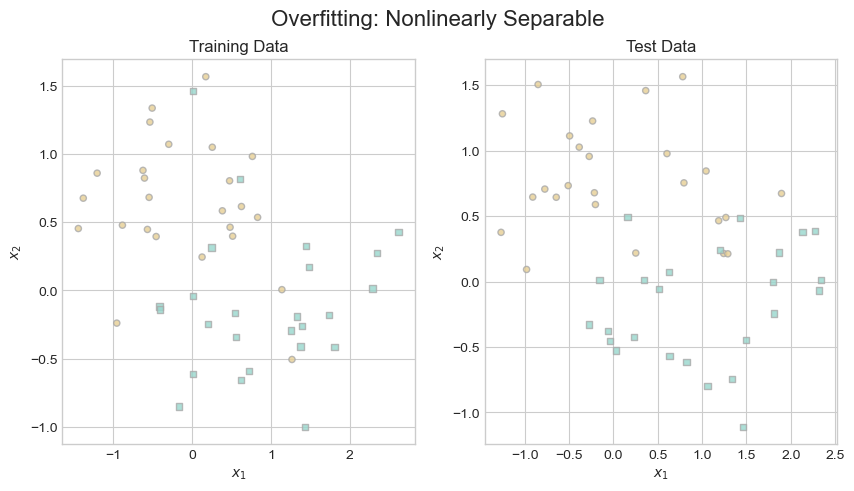

In [95]:
def make_moons_train_test(n, shuffle=True, noise=0.4):
    X, y = make_moons(n, shuffle=shuffle, noise=noise)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

#convert to torch tensors
X_train, y_train = make_moons_train_test(50, shuffle=True)
X_test, y_test = make_moons_train_test(50, shuffle=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_classification_data(X_train, y_train, ax[0])
ax[0].set_title("Training Data")
plot_classification_data(X_test, y_test, ax[1])
ax[1].set_title("Test Data")
fig.suptitle("Overfitting: Nonlinearly Separable", fontsize=16)




As we can see our training and test data have similar trends, but also significant variation. if we fit the training data too closely we will most likely overfit the model.

Let's making a training loop so that we can track accuracy of train and test data at each iteration.

In [96]:
def train_model(model, num_steps, X_train, y_train, X_test, y_test, lr):
    model.Xt = X_train

    if model.a is None:
        model.a = torch.zeros(X_train.shape[0], requires_grad=False)


    # instantiate an optimizer -- gradient descent today
    opt = GradientDescentOptimizer(model)

    # collect the values of the loss in each step
    acc_train_vec = []
    acc_test_vec   = []



    for i in range(num_steps): 
                
        opt.step(X_train, y_train, lr=lr)  

        # for tracking model progress on the training set
        train_acc = (model.predict(X_train) == y_train).float().mean()   
        acc_train_vec.append(train_acc.item())   

        test_acc = (model.predict(X_test) == y_test).float().mean()
        acc_test_vec.append(test_acc.item())

    return acc_train_vec, acc_test_vec


# KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 10)
# loss_train, loss_test = train_model(model = KR, num_steps=5000, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, lr = 0.01)

The following experiment will track each step in the fitting of the model to our training data, recording the models accuracy on the training and testing data at each step. In doing so we can track the performance of the model with each iteration.

In [97]:
def plot_experiment(model):
    fig, ax = plt.subplots(1, 3, figsize = (9, 3))
    acc_train, acc_test = train_model(model = model, num_steps=50000, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, lr = 0.01)  
    ax[0].plot(acc_train, c = "steelblue", label = "Training")
    ax[0].plot(acc_test, c = "goldenrod", label = "Testing")
    ax[0].set(xlabel = "Iteration", ylabel = "Accuracy")
    ax[0].legend()
    ax[0].set_title("Training and Testing Accuracy vs Iteration")
    ax[1].set_title("Training Data")
    ax[2].set_title("Testing Data")    

    plot_decision_boundary(model, X_train, y_train, ax = ax[1], highlight=True)  
    plot_decision_boundary(model, X_test, y_test, ax = ax[2], highlight=False)   
    plt.tight_layout()



Now let's plot our findings.

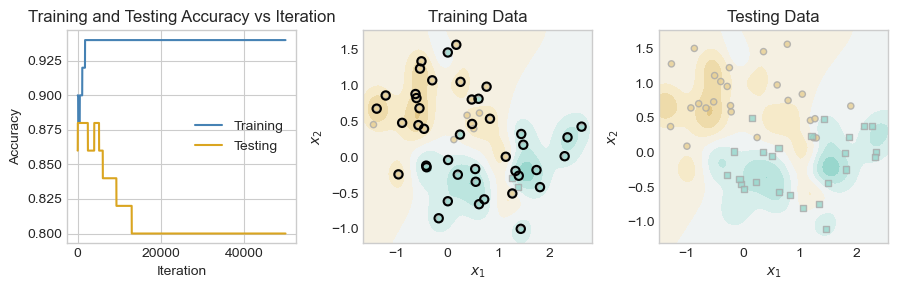

In [98]:
KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 10)
plot_experiment(KR)

Fascinating. As we can see in the first plot, our accuracy begins relatively high for both our testing and training data, but decreases on the testing data as more iterations occur. This makes sense when looking at the decision regions. We have highly localized decision regions built around the training data, that does not fit the variation of the testing data. 

In [99]:

accuracy = (KR.predict(X_train) == y_train).float().mean()
print(f"Train accuracy: {accuracy:.2f}")

Train accuracy: 0.94


The result of this is that we have a very high training accuracy, but this is not a good thing.

In [58]:
accuracy = (KR.predict(X_test) == y_test).float().mean()
print(f"Test accuracy: {accuracy:.2f}")

Test accuracy: 0.80


Our testing accuracy is significantly worse. 

## Discussion

As we have demonstrated in the blog post, using sparse kernel machines gives significantly more control over how our models are fit. With control of the bandwidth (gamma), or the relationship between the distance between two points and the similarity of them, and lambda, the regularization of the weights, we can get very high accuracy when training models. This can even be done on non-linearly separable data. But this comes with risks. If we fit the data too much on the training data, then variation in training and testing data will result in overfitting. This was demonstrated in Part B, where we showed that a highly localized and non-normalized training of non linear data with a decent amount of noise will result in a poor performance when tresting our model.

All of this blog post demonstrates the importance of cross validation for the selection of parameters during training in order to prevent overfitting. But cross validation requires more time, energy, and computing power.